In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [219]:
import matplotlib.cm as cm  # Para usar una paleta de colores continua
from networkx.drawing.nx_agraph import graphviz_layout

def mostrar_grafo(G):
    plt.figure(figsize=(10,10))
    #pos = nx.spring_layout(G,k=1)
    #pos=nx.circular_layout(G)
    #pos=nx.shell_layout(G)
    #pos=nx.random_layout(G)
    #pos = graphviz_layout(G, prog='dot')
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    
    pos = nx.spring_layout(G)
    #pos = nx.kamada_kawai_layout(G)
    
    # Obtener todos los valores de profundidad para ajustar el rango de colores
    profundidades = [G.nodes[node].get('profundidad', 0) for node in G.nodes]
    
    # Normalizar las profundidades para asignar colores continuos en una escala
    min_prof, max_prof = min(profundidades), max(profundidades)
    colors = [
        cm.viridis((prof - min_prof) / (max_prof - min_prof)) if max_prof > min_prof else cm.viridis(0.5)
        for prof in profundidades
    ]
    
    nx.draw(G,pos,with_labels=False, node_color=colors, edge_color="gray", node_size=2000, font_size=10)
    # Prepara las etiquetas con atributos de cada nodo
    labels = {node: f"n:{node}\np:{G.nodes[node].get('profundidad', '')}" for node in G.nodes}
    
    # Dibuja las etiquetas de los nodos con sus atributos
    nx.draw_networkx_labels(G, pos, labels, font_size=15, font_color="white")
    
    plt.margins(0.2)
    plt.show()

In [4]:
def dibujar_arbol(grafo, nodo_raiz=1):
    # Asegurarse de que el grafo sea dirigido
    if not nx.is_directed(grafo):
        raise ValueError("El grafo debe ser dirigido.")
    
    # Calcular la distancia desde el nodo raíz a todos los demás nodos
    distancias = nx.single_source_shortest_path_length(grafo, nodo_raiz)
    
    # Crear la estructura de posiciones de nodos
    pos = {nodo_raiz: (0, 0)}  # Posición inicial del nodo raíz en el centro
    nivel_offset = 1.5  # Espaciado inicial en el eje x para los hijos de cada nodo
    procesados = {nodo_raiz}  # Conjunto para marcar nodos ya procesados
    
    def asignar_posiciones(nodo, profundidad, offset_x):
        """ Función recursiva para asignar posiciones a los nodos """
        hijos = list(grafo.successors(nodo))
        num_hijos = len(hijos)
        
        if num_hijos == 0:
            return  # Si no tiene hijos, termina la recursión
        
        # Calcular el espaciado para los hijos basado en el nivel de profundidad
        espacio_hijos = offset_x / max(1, num_hijos - 1)  # Reduce el offset en cada nivel
        
        for i, hijo in enumerate(hijos):
            # Asigna posición al hijo basado en su índice
            pos[hijo] = (
                pos[nodo][0] + (i - (num_hijos - 1) / 2) * espacio_hijos,  # x
                pos[nodo][1] - 0.5  # y, bajamos en el eje vertical para el nivel
            )
            procesados.add(hijo)
            # Llamada recursiva para colocar los descendientes del hijo
            asignar_posiciones(hijo, profundidad + 1, offset_x / 2)
    
    # Iniciar la colocación de nodos desde la raíz
    asignar_posiciones(nodo_raiz, 0, nivel_offset * len(distancias))
    
    # Dibujar el grafo usando las posiciones calculadas
    plt.figure(figsize=(10, 10,))
    nx.draw(grafo, pos=pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
    
    # Mostrar el gráfico
    plt.title(f'Árbol generado a partir del grafo dirigido (Raíz: Nodo {nodo_raiz})')
    plt.show()

In [6]:
def describir_arbol(G):
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)
    
def describir_arbol_aux(nodo, G, profundidad):
    hijos = list(G.successors(nodo))
    resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
    if hijos != []:
        for hijo in hijos:
            resultado+=describir_arbol_aux(hijo,G,profundidad+1)
    return resultado

In [8]:
def hojas_preorden(G):
    hojas = {n for n, out_d in G.out_degree() if out_d == 0}
    recorrido_preorden = list(nx.dfs_preorder_nodes(G, source=1))
    lista_hojas = [nodo for nodo in recorrido_preorden if nodo in hojas]
    return lista_hojas

#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [239]:
import random

def formar_particion_estado_4(n):
    lista_hojas = []
        
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    
    lista_hojas.append(1)
    nodos=1
    
    for i in range(1,n+1):
        selec = random.choice(lista_hojas)
        profundidad = nx.shortest_path_length(A, source=1,target=selec)+1
        
        if profundidad == 5:
            continue
            
        if profundidad > A.graph['altura']:
            A.graph['altura'] = profundidad
        
        A.add_node(nodos+1,profundidad=profundidad)
        A.add_node(nodos+2,profundidad=profundidad)
        A.add_node(nodos+3,profundidad=profundidad)
        A.add_node(nodos+4,profundidad=profundidad)
        A.add_edges_from([(selec,nodos+1),(selec,nodos+2),(selec,nodos+3),(selec,nodos+4)])
        #print("Añadidos hijos "+str(nodos+1)+" y "+str(nodos+2))
        lista_hojas.append(nodos+1)
        lista_hojas.append(nodos+2)
        lista_hojas.append(nodos+3)
        lista_hojas.append(nodos+4)
        lista_hojas.remove(selec)
        
        nodos+=4
    return A

In [240]:
A = formar_particion_estado_4(2)

In [241]:
describir_arbol(A)


Nodo: 1 | Profundidad: 0
	Nodo: 2 | Profundidad: 1
	Nodo: 3 | Profundidad: 1
	Nodo: 4 | Profundidad: 1
	Nodo: 5 | Profundidad: 1
		Nodo: 6 | Profundidad: 2
		Nodo: 7 | Profundidad: 2
		Nodo: 8 | Profundidad: 2
		Nodo: 9 | Profundidad: 2


In [9]:
import matplotlib.patches as patches

class Cuadrado():
    def __init__(self, G, nodo=1, centro=(0, 0), tamaño=10):
        self.G=G
        tipos = ['suelo','suelo','pared']
        self.nodo = nodo
        self.centro = centro
        self.tamaño = tamaño
        self.tipo = random.choice(tipos)

        self.profundidad = self.G.graph['altura']

        self.cuadrantes = []

        self.hijos = []

        hijos = list(self.G.successors(nodo))

        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))

    def __str__(self):
        """
        Representación en texto del cuadrado.
        """
        return f"Cuadrado(nodo={self.nodo},tamaño={self.tamaño},tipo={self.tipo},centro={self.centro})"

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)

    def dibujar(self, ax):
        # Dibuja el cuadrado actual
        x, y = self.centro
        tamaño = self.tamaño
        if self.tipo == 'pared':
            rect = patches.Rectangle(
                (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                linewidth=1, edgecolor='grey', facecolor='black'
            )
            ax.add_patch(rect)
        elif self.tipo == 'suelo':
            rect = patches.Rectangle(
                (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                linewidth=1, edgecolor='grey', facecolor='white'
            )
            ax.add_patch(rect)

        # Dibujar los hijos
        for cuadrante in self.cuadrantes:
            cuadrante.dibujar(ax)

In [10]:
G = formar_particion_estado_4(400)

cuadrado = Cuadrado(G)
cuadrado.imprimir_estructura()


[6, 14, 15, 16, 17, 26, 27, 28, 29, 34, 35, 36, 37, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 122, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 186, 187, 188, 189, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
Cuadrado(nodo=1,tamaño=10,tipo=suelo,centro=(0, 0))
    Cuadrado(nodo=2,tamaño=5.0,tipo=suelo,centro=(-2.5, 2.5))
      

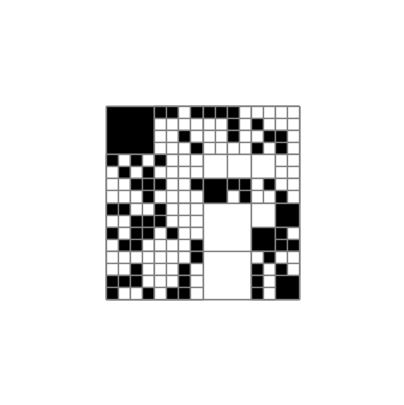

In [11]:
#cuadrado.imprimir_estructura()
#print(cuadrado.profundidad)
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal')
ax.axis('off')

# Configuración del fondo transparente
fig.patch.set_alpha(0)  # Fondo de la figura transparente
ax.patch.set_alpha(0)   # Fondo del eje transparente

cuadrado.dibujar(ax)

plt.show()

In [230]:
A,G = formar_particion_estado_4(4)
#mostrar_grafo(G)

Dividido nodo 1 en los nodos 2, 3, 4, 5

Contiguos del nodo 2 = [0, 3, 4, 0]
Contiguos del nodo 3 = [0, 0, 5, 2]
Contiguos del nodo 4 = [2, 5, 0, 0]
Contiguos del nodo 5 = [3, 0, 0, 4]

Conectado (2 y 3)
Conectado (2 y 4)
Conectado (3 y 5)
Conectado (3 y 2)
Conectado (4 y 2)
Conectado (4 y 5)
Conectado (5 y 3)
Conectado (5 y 4)

Eliminado nodo 1

+---+---+---+---+---+---+---+---+---+---+---+---+

Dividido nodo 3 en los nodos 6, 7, 8, 9

Contiguos del nodo 6 = [0, 7, 8, 0]
Contiguos del nodo 7 = [0, 0, 9, 6]
Contiguos del nodo 8 = [6, 9, 0, 0]
Contiguos del nodo 9 = [7, 0, 0, 8]

Conectado (6 y 7)
Conectado (6 y 8)
Conectado (7 y 9)
Conectado (7 y 6)
Conectado (8 y 6)
Conectado (8 y 9)
Conectado (9 y 7)
Conectado (9 y 8)

Para el nodo 3:
	Cuadrado arriba: 0
	Cuadrado derecha: 0
	Cuadrado abajo: 5
	Cuadrado izquierda: 2

	Conectado (5 y 8)
	Conectado (5 y 9)
		Añadido contiguo 5 a 8
		Añadido contiguo 5 a 9

	Conectado (2 y 6)
	Conectado (2 y 8)
		Añadido contiguo 2 a 6
		Añadido contigu

In [232]:
describir_arbol(A)

Nodo: 1 | Profundidad: 0
	Nodo: 2 | Profundidad: 1
	Nodo: 3 | Profundidad: 1
		Nodo: 6 | Profundidad: 2
		Nodo: 7 | Profundidad: 2
		Nodo: 8 | Profundidad: 2
		Nodo: 9 | Profundidad: 2
			Nodo: 14 | Profundidad: 3
			Nodo: 15 | Profundidad: 3
			Nodo: 16 | Profundidad: 3
			Nodo: 17 | Profundidad: 3
	Nodo: 4 | Profundidad: 1
	Nodo: 5 | Profundidad: 1
		Nodo: 10 | Profundidad: 2
		Nodo: 11 | Profundidad: 2
		Nodo: 12 | Profundidad: 2
		Nodo: 13 | Profundidad: 2


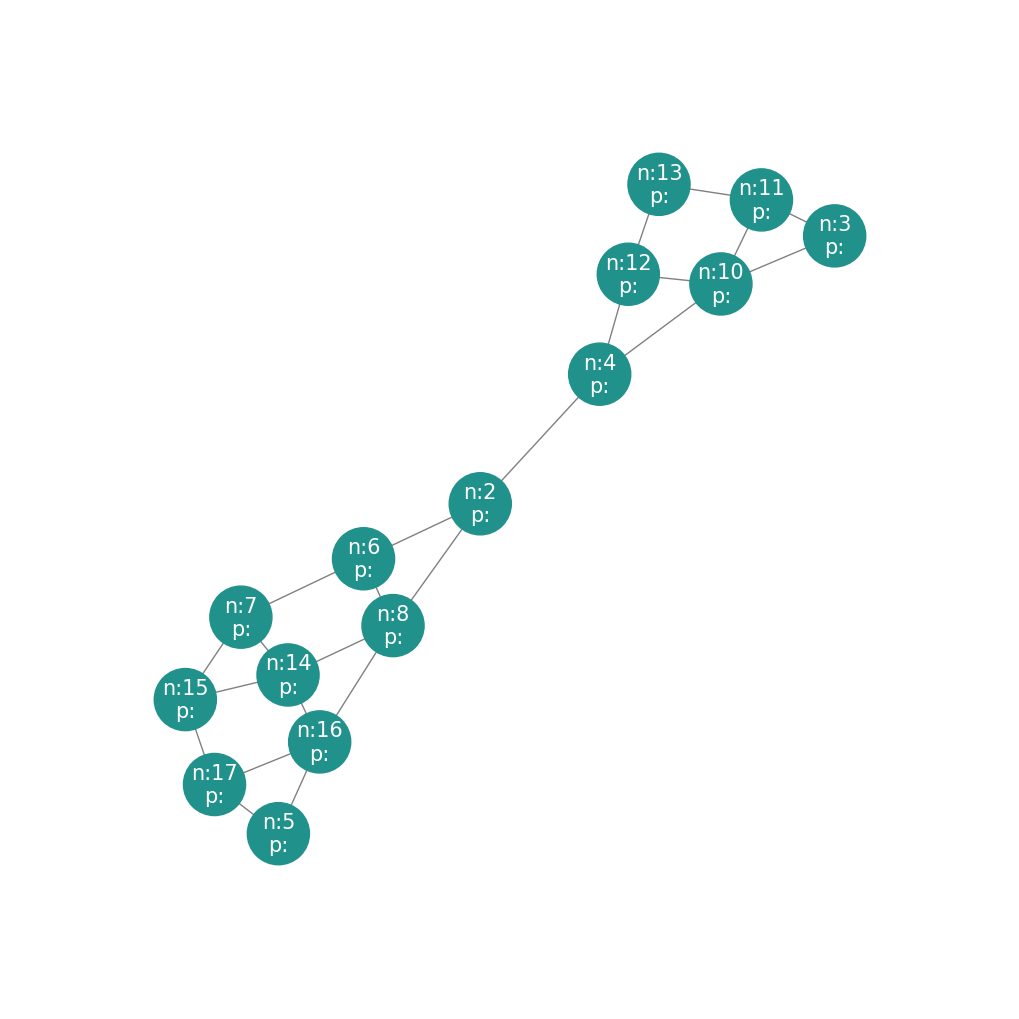

In [231]:
mostrar_grafo(G)

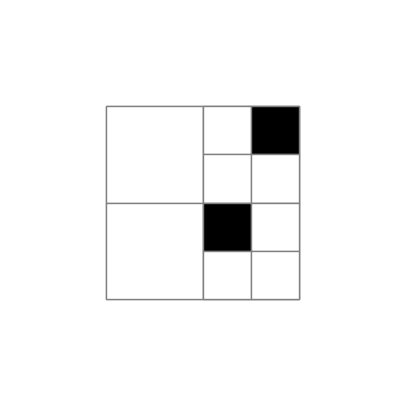

In [212]:
cuadrado = Cuadrado(A)
#cuadrado.imprimir_estructura()
#print(cuadrado.profundidad)
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal')
ax.axis('off')

# Configuración del fondo transparente
fig.patch.set_alpha(0)  # Fondo de la figura transparente
ax.patch.set_alpha(0)   # Fondo del eje transparente

cuadrado.dibujar(ax)

plt.show()